In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=9, padding=2, padding_mode='replicate') # padding mode same as original Caffe code
        self.conv2 = nn.Conv2d(128, 64, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(64, 1, kernel_size=5, padding=2, padding_mode='replicate')
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [ ]:
# learning parameters
batch_size = 64 # batch size, reduce if facing OOM error
epochs = 100 # number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
img_rows, img_cols = 33, 33
out_rows, out_cols = 33, 33

In [ ]:
file = h5py.File('/content/drive/MyDrive/input/train_mscale.h5')
# `in_train` has shape (21884, 33, 33, 1) which corresponds to
# 21884 image patches of 33 pixels height & width and 1 color channel
in_train = file['data'][:] # the training data
out_train = file['label'][:] # the training labels
file.close()
# change the values to float32
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [ ]:
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  16368
Validation samples:  5456


In [ ]:
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [ ]:
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

Computation device:  cpu
SRCNN(
  (conv1): Conv2d(1, 128, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [ ]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [ ]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        #save_image(outputs, f"../outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [ ]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):#epochs
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 100


256it [02:45,  1.55it/s]
86it [00:16,  5.25it/s]                        


Train PSNR: 24.880
Val PSNR: 26.825
Epoch 2 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.14it/s]                        


Train PSNR: 26.767
Val PSNR: 27.234
Epoch 3 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.13it/s]                        


Train PSNR: 26.998
Val PSNR: 27.407
Epoch 4 of 100


256it [02:40,  1.60it/s]
86it [00:16,  5.08it/s]                        


Train PSNR: 27.132
Val PSNR: 27.428
Epoch 5 of 100


256it [02:41,  1.58it/s]
86it [00:16,  5.18it/s]                        


Train PSNR: 27.207
Val PSNR: 27.525
Epoch 6 of 100


256it [02:42,  1.58it/s]
86it [00:16,  5.11it/s]                        


Train PSNR: 27.249
Val PSNR: 27.618
Epoch 7 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.18it/s]                        


Train PSNR: 27.282
Val PSNR: 27.669
Epoch 8 of 100


256it [02:41,  1.59it/s]
86it [00:17,  5.05it/s]                        


Train PSNR: 27.319
Val PSNR: 27.707
Epoch 9 of 100


256it [02:42,  1.58it/s]
86it [00:16,  5.19it/s]                        


Train PSNR: 27.351
Val PSNR: 27.732
Epoch 10 of 100


256it [02:42,  1.57it/s]
86it [00:17,  5.01it/s]                        


Train PSNR: 27.379
Val PSNR: 27.761
Epoch 11 of 100


256it [02:41,  1.58it/s]
86it [00:17,  5.05it/s]                        


Train PSNR: 27.402
Val PSNR: 27.798
Epoch 12 of 100


256it [02:41,  1.58it/s]
86it [00:16,  5.13it/s]                        


Train PSNR: 27.429
Val PSNR: 27.823
Epoch 13 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.11it/s]                        


Train PSNR: 27.461
Val PSNR: 27.843
Epoch 14 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.96it/s]                        


Train PSNR: 27.486
Val PSNR: 27.856
Epoch 15 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.94it/s]                        


Train PSNR: 27.504
Val PSNR: 27.806
Epoch 16 of 100


256it [02:44,  1.56it/s]
86it [00:17,  4.88it/s]                        


Train PSNR: 27.541
Val PSNR: 27.870
Epoch 17 of 100


256it [02:43,  1.57it/s]
86it [00:16,  5.12it/s]                        


Train PSNR: 27.566
Val PSNR: 27.919
Epoch 18 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.09it/s]                        


Train PSNR: 27.583
Val PSNR: 27.960
Epoch 19 of 100


256it [02:42,  1.58it/s]
86it [00:16,  5.10it/s]                        


Train PSNR: 27.608
Val PSNR: 27.977
Epoch 20 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.95it/s]                        


Train PSNR: 27.597
Val PSNR: 27.984
Epoch 21 of 100


256it [02:41,  1.58it/s]
86it [00:17,  5.04it/s]                        


Train PSNR: 27.654
Val PSNR: 28.022
Epoch 22 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.99it/s]                        


Train PSNR: 27.644
Val PSNR: 28.017
Epoch 23 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.95it/s]                        


Train PSNR: 27.688
Val PSNR: 28.053
Epoch 24 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.91it/s]                        


Train PSNR: 27.689
Val PSNR: 28.065
Epoch 25 of 100


256it [02:43,  1.56it/s]
86it [00:17,  4.93it/s]                        


Train PSNR: 27.713
Val PSNR: 28.098
Epoch 26 of 100


256it [02:40,  1.59it/s]
86it [00:17,  5.03it/s]                        


Train PSNR: 27.655
Val PSNR: 27.962
Epoch 27 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.10it/s]                        


Train PSNR: 27.722
Val PSNR: 28.005
Epoch 28 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.10it/s]                        


Train PSNR: 27.699
Val PSNR: 27.983
Epoch 29 of 100


256it [02:40,  1.60it/s]
86it [00:17,  5.05it/s]                        


Train PSNR: 27.789
Val PSNR: 28.135
Epoch 30 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.15it/s]                        


Train PSNR: 27.737
Val PSNR: 28.086
Epoch 31 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.08it/s]                        


Train PSNR: 27.775
Val PSNR: 28.089
Epoch 32 of 100


256it [02:41,  1.58it/s]
86it [00:16,  5.10it/s]                        


Train PSNR: 27.790
Val PSNR: 28.067
Epoch 33 of 100


256it [02:40,  1.60it/s]
86it [00:16,  5.09it/s]                        


Train PSNR: 27.850
Val PSNR: 28.178
Epoch 34 of 100


256it [02:39,  1.60it/s]
86it [00:16,  5.16it/s]                        


Train PSNR: 27.818
Val PSNR: 28.121
Epoch 35 of 100


256it [02:39,  1.61it/s]
86it [00:16,  5.14it/s]                        


Train PSNR: 27.864
Val PSNR: 28.148
Epoch 36 of 100


256it [02:40,  1.60it/s]
86it [00:16,  5.10it/s]                        


Train PSNR: 27.876
Val PSNR: 28.242
Epoch 37 of 100


256it [02:40,  1.60it/s]
86it [00:16,  5.08it/s]                        


Train PSNR: 27.891
Val PSNR: 28.187
Epoch 38 of 100


256it [02:40,  1.59it/s]
86it [00:17,  5.05it/s]                        


Train PSNR: 27.878
Val PSNR: 28.207
Epoch 39 of 100


256it [02:41,  1.59it/s]
86it [00:17,  5.03it/s]                        


Train PSNR: 27.867
Val PSNR: 28.146
Epoch 40 of 100


256it [02:41,  1.58it/s]
86it [00:17,  5.03it/s]                        


Train PSNR: 27.924
Val PSNR: 28.084
Epoch 41 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.09it/s]                        


Train PSNR: 27.874
Val PSNR: 28.235
Epoch 42 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.15it/s]                        


Train PSNR: 27.946
Val PSNR: 28.211
Epoch 43 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.10it/s]                        


Train PSNR: 27.947
Val PSNR: 28.318
Epoch 44 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.09it/s]                        


Train PSNR: 27.976
Val PSNR: 28.291
Epoch 45 of 100


256it [02:42,  1.57it/s]
86it [00:16,  5.13it/s]                        


Train PSNR: 27.995
Val PSNR: 28.281
Epoch 46 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.07it/s]                        


Train PSNR: 27.969
Val PSNR: 28.187
Epoch 47 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.07it/s]                        


Train PSNR: 28.008
Val PSNR: 28.382
Epoch 48 of 100


256it [02:41,  1.58it/s]
86it [00:16,  5.14it/s]                        


Train PSNR: 27.899
Val PSNR: 28.306
Epoch 49 of 100


256it [02:41,  1.59it/s]
86it [00:16,  5.13it/s]                        


Train PSNR: 28.021
Val PSNR: 28.360
Epoch 50 of 100


256it [02:42,  1.58it/s]
86it [00:16,  5.15it/s]                        


Train PSNR: 28.034
Val PSNR: 28.306
Epoch 51 of 100


256it [02:40,  1.60it/s]
86it [00:16,  5.17it/s]                        


Train PSNR: 28.023
Val PSNR: 28.368
Epoch 52 of 100


256it [02:40,  1.59it/s]
86it [00:16,  5.19it/s]                        


Train PSNR: 28.056
Val PSNR: 28.447
Epoch 53 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.91it/s]                        


Train PSNR: 28.026
Val PSNR: 28.420
Epoch 54 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.92it/s]                        


Train PSNR: 28.073
Val PSNR: 28.405
Epoch 55 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.072
Val PSNR: 28.446
Epoch 56 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.88it/s]                        


Train PSNR: 28.068
Val PSNR: 28.461
Epoch 57 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.85it/s]                        


Train PSNR: 28.046
Val PSNR: 28.336
Epoch 58 of 100


256it [02:44,  1.56it/s]
86it [00:17,  4.83it/s]                        


Train PSNR: 28.088
Val PSNR: 28.435
Epoch 59 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.89it/s]                        


Train PSNR: 27.877
Val PSNR: 28.121
Epoch 60 of 100


256it [02:43,  1.56it/s]
86it [00:17,  4.89it/s]                        


Train PSNR: 28.051
Val PSNR: 28.320
Epoch 61 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.040
Val PSNR: 28.378
Epoch 62 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.96it/s]                        


Train PSNR: 28.091
Val PSNR: 28.467
Epoch 63 of 100


256it [02:41,  1.58it/s]
86it [00:17,  4.89it/s]                        


Train PSNR: 28.099
Val PSNR: 28.379
Epoch 64 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.106
Val PSNR: 28.465
Epoch 65 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.94it/s]                        


Train PSNR: 28.130
Val PSNR: 28.483
Epoch 66 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.95it/s]                        


Train PSNR: 28.139
Val PSNR: 28.519
Epoch 67 of 100


256it [02:40,  1.59it/s]
86it [00:17,  4.96it/s]                        


Train PSNR: 28.131
Val PSNR: 28.463
Epoch 68 of 100


256it [02:40,  1.59it/s]
86it [00:17,  4.89it/s]                        


Train PSNR: 28.058
Val PSNR: 28.477
Epoch 69 of 100


256it [02:41,  1.59it/s]
86it [00:17,  4.98it/s]                        


Train PSNR: 28.142
Val PSNR: 28.434
Epoch 70 of 100


256it [02:41,  1.58it/s]
86it [00:17,  4.91it/s]                        


Train PSNR: 28.160
Val PSNR: 28.513
Epoch 71 of 100


256it [02:41,  1.58it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.171
Val PSNR: 28.543
Epoch 72 of 100


256it [02:41,  1.59it/s]
86it [00:17,  4.88it/s]                        


Train PSNR: 28.152
Val PSNR: 28.481
Epoch 73 of 100


256it [02:41,  1.59it/s]
86it [00:17,  4.92it/s]                        


Train PSNR: 28.146
Val PSNR: 28.505
Epoch 74 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.89it/s]                        


Train PSNR: 28.090
Val PSNR: 28.447
Epoch 75 of 100


256it [02:44,  1.56it/s]
86it [00:17,  4.87it/s]                        


Train PSNR: 28.181
Val PSNR: 28.481
Epoch 76 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.93it/s]                        


Train PSNR: 28.172
Val PSNR: 28.489
Epoch 77 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.91it/s]                        


Train PSNR: 28.215
Val PSNR: 28.524
Epoch 78 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.208
Val PSNR: 28.559
Epoch 79 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.119
Val PSNR: 28.528
Epoch 80 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.92it/s]                        


Train PSNR: 28.240
Val PSNR: 28.367
Epoch 81 of 100


256it [02:43,  1.57it/s]
86it [00:18,  4.74it/s]                        


Train PSNR: 28.193
Val PSNR: 28.444
Epoch 82 of 100


256it [02:44,  1.55it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.131
Val PSNR: 28.382
Epoch 83 of 100


256it [02:44,  1.56it/s]
86it [00:17,  4.91it/s]                        


Train PSNR: 28.211
Val PSNR: 28.502
Epoch 84 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.88it/s]                        


Train PSNR: 28.208
Val PSNR: 28.558
Epoch 85 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.232
Val PSNR: 28.551
Epoch 86 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.227
Val PSNR: 28.594
Epoch 87 of 100


256it [02:44,  1.56it/s]
86it [00:17,  4.80it/s]                        


Train PSNR: 28.203
Val PSNR: 28.448
Epoch 88 of 100


256it [02:42,  1.57it/s]
86it [00:17,  4.91it/s]                        


Train PSNR: 28.240
Val PSNR: 28.573
Epoch 89 of 100


256it [02:42,  1.58it/s]
86it [00:17,  4.94it/s]                        


Train PSNR: 27.964
Val PSNR: 28.354
Epoch 90 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.90it/s]                        


Train PSNR: 28.159
Val PSNR: 28.463
Epoch 91 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.93it/s]                        


Train PSNR: 28.221
Val PSNR: 28.565
Epoch 92 of 100


256it [02:44,  1.55it/s]
86it [00:17,  4.86it/s]                        


Train PSNR: 28.221
Val PSNR: 28.528
Epoch 93 of 100


256it [02:43,  1.57it/s]
86it [00:17,  4.87it/s]                        


Train PSNR: 28.255
Val PSNR: 28.603
Epoch 94 of 100


256it [02:47,  1.53it/s]
86it [00:18,  4.77it/s]                        


Train PSNR: 28.206
Val PSNR: 28.474
Epoch 95 of 100


256it [02:48,  1.52it/s]
86it [00:18,  4.71it/s]                        


Train PSNR: 28.253
Val PSNR: 28.522
Epoch 96 of 100


256it [02:46,  1.54it/s]
86it [00:17,  4.86it/s]                        


Train PSNR: 28.257
Val PSNR: 28.553
Epoch 97 of 100


256it [02:47,  1.53it/s]
86it [00:18,  4.71it/s]                        


Train PSNR: 28.138
Val PSNR: 28.490
Epoch 98 of 100


256it [02:46,  1.54it/s]
86it [00:17,  4.86it/s]                        


Train PSNR: 28.273
Val PSNR: 28.579
Epoch 99 of 100


256it [02:49,  1.51it/s]
86it [00:18,  4.75it/s]                        


Train PSNR: 28.198
Val PSNR: 28.280
Epoch 100 of 100


256it [02:47,  1.53it/s]
86it [00:17,  4.82it/s]                        

Train PSNR: 28.250
Val PSNR: 28.582
Finished training in: 299.633 minutes


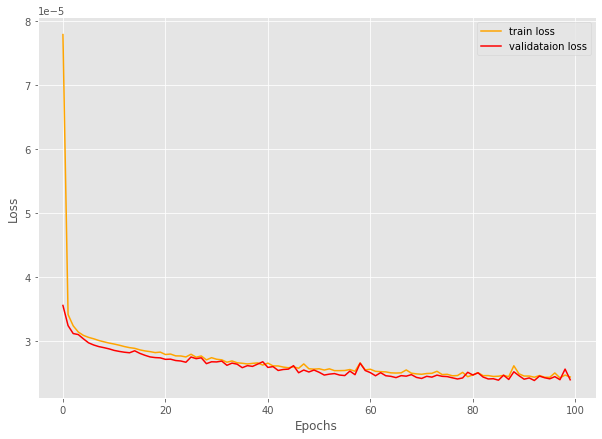

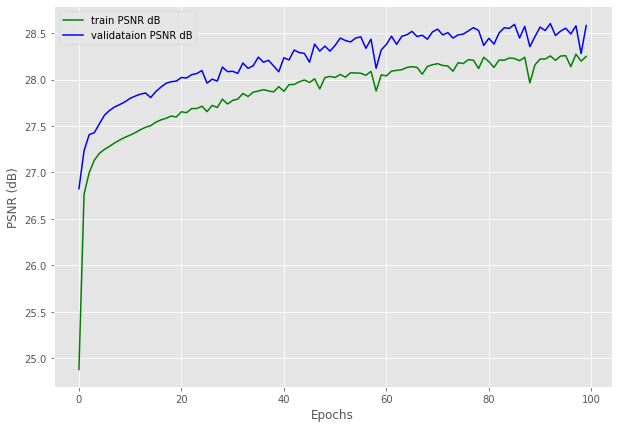

Saving model...


In [ ]:
#saving
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/outputs/loss.png')
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig('/content/outputs/psnr.png')
plt.show()
#torch.save(model, 'srcnn.pkl')
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '/content/outputs/model2.pth')

In [ ]:
import torch
import cv2
#import srcnn
import numpy as np
import glob as glob
import os
from torchvision.utils import save_image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = SRCNN().to(device)
model.load_state_dict(torch.load('../outputs/model.pth'))

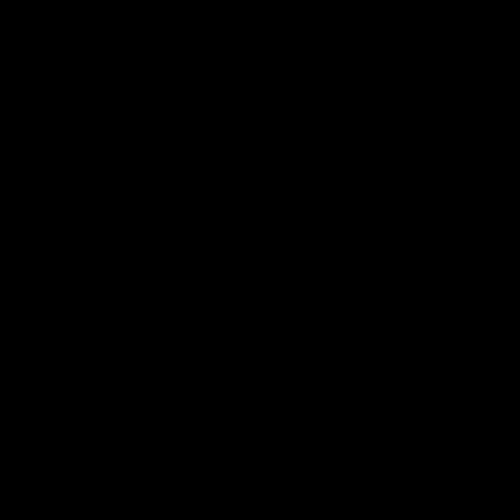

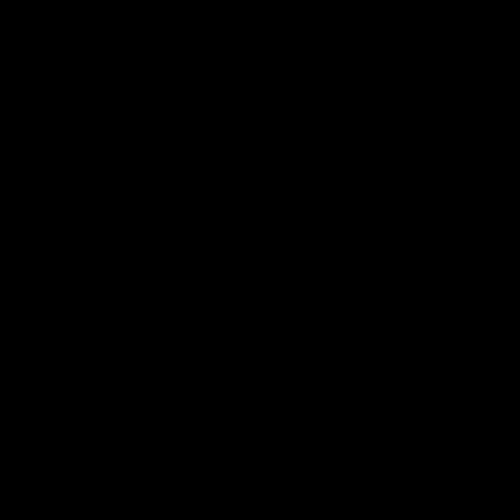

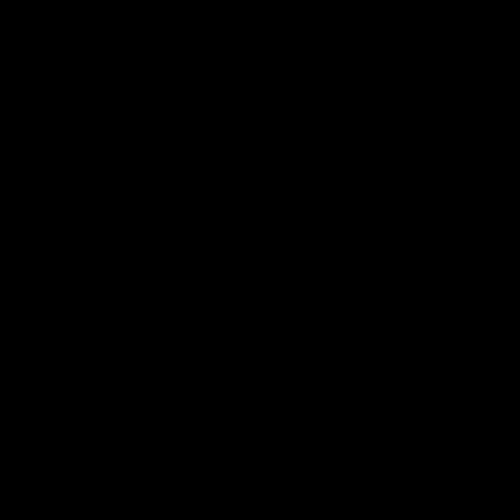

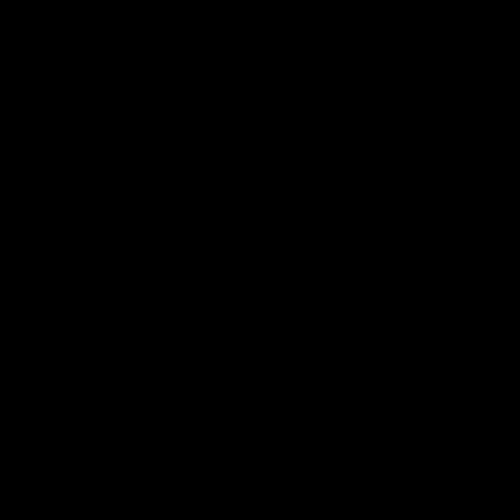

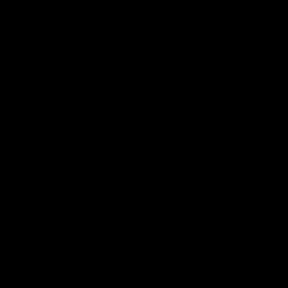

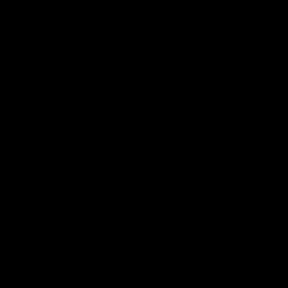

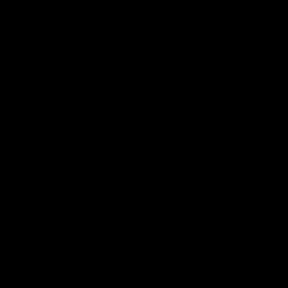

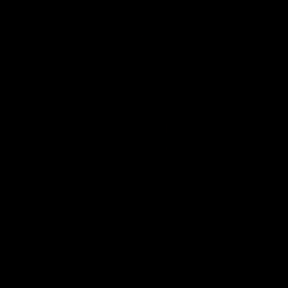

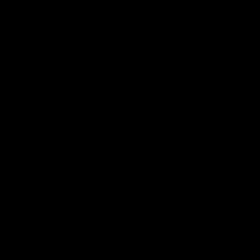

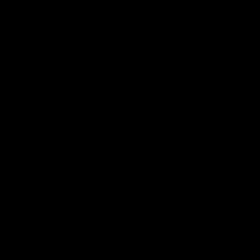

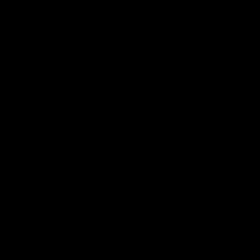

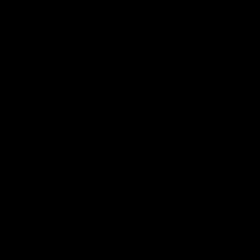

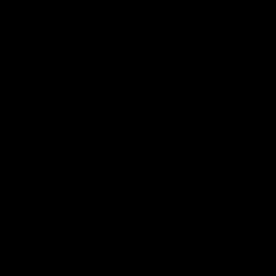

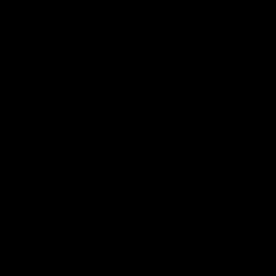

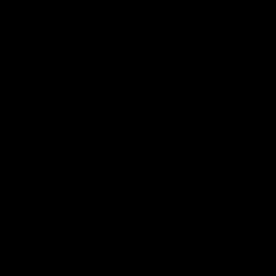

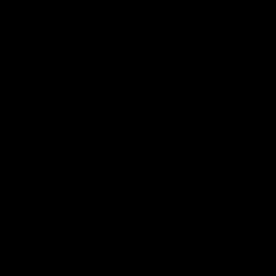

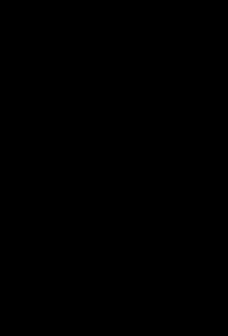

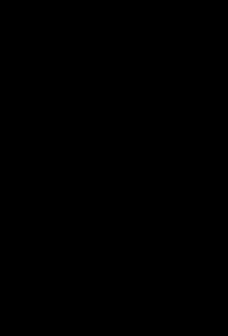

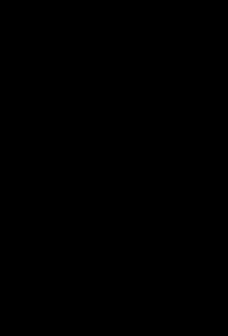

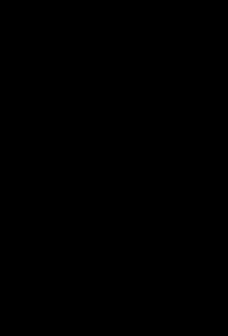

In [ ]:
from google.colab.patches import cv2_imshow
image_paths = glob.glob('/content/drive/MyDrive/input/bicubic_2x/*')
for image_path in image_paths:
    outp=[]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    test_image_name = image_path.split(os.path.sep)[-1].split('.')[0]
    cv2.imwrite(f"/content/outputs/test_{test_image_name}.png", image)
    for i in range(3):
        im = image[:,:,i]
        im = im.reshape(im.shape[0], im.shape[1], 1)
        im = im / 255.
        cv2_imshow(im)
        model.eval()
        with torch.no_grad():
            im = np.transpose(im, (2, 0, 1)).astype(np.float32)
            im = torch.tensor(im, dtype=torch.float).to(device)
            im = im.unsqueeze(0)
            outputs = model(im)
            outputs = outputs.cpu()
            outputs = outputs.detach().numpy()
            outputs = outputs.reshape(outputs.shape[2], outputs.shape[3], outputs.shape[1])
            outp.append(outputs)
    res = np.concatenate((outp[0], outp[1], outp[2]), axis=2)
    cv2.imwrite(f"/content/outputs/output_{test_image_name}.png", res*255)
    cv2_imshow(res)